# Load Data

In [1]:
!pip install gdown --q

In [2]:
!pip install datasets --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [3]:
from datasets import load_dataset

dataset = load_dataset("Bahareh0281/liveness_images")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6427 [00:00<?, ? examples/s]

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
# def load_image_paths(directory):
#     image_paths = []
#     for filename in os.listdir(directory):
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             image_paths.append(os.path.join(directory, filename))
#     return image_paths

# image_paths = load_image_paths('/content/train_img/train_img/color')

In [6]:
# output_dir = '/content/train_img/train_img/color'

## Labels Extraction

In [7]:
dataset['train'][0]['label']

0

## Load [Our Videos](https://drive.google.com/file/d/1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA/view?usp=sharing)

In [8]:
import gdown

file_id = '1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA'
destination = '/content/dataset.zip'  # Path where the file will be saved
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

import zipfile

with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Downloading...
From (original): https://drive.google.com/uc?id=1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA
From (redirected): https://drive.google.com/uc?id=1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA&confirm=t&uuid=ce55f349-a2aa-40cf-a7e3-4fd925b2519d
To: /content/dataset.zip
100%|██████████| 377M/377M [00:02<00:00, 156MB/s]


### Random Frame Extraction

In [9]:
import os
import random
import cv2
from PIL import Image

In [10]:
def extract_frames(video_path, save_path, label, test, filename):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Select one random frame
    random_frame = random.randint(0, frame_count - 1)

    # Set the position of the video to the selected frame
    video.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
    success, frame = video.read()

    # If the frame was successfully read, save it
    if success:
        frame_path = os.path.join(save_path, f"{label}_{filename.split('.')[0]}.jpg")
        cv2.imwrite(frame_path, frame)

        # Convert the frame to a PIL image
        pil_image = Image.open(frame_path)

        # Save the image and label to the dictionary
        test.append({'image': pil_image, 'label': label})

    # Release the video file
    video.release()

In [11]:
import cv2

fake_test_videos_path = '/content/dataset/fake/test'
real_test_videos_path = '/content/dataset/real/test'

save_frames_path = '/content/extracted_frames/test'
# Create the directory if it doesn't exist
if not os.path.exists(save_frames_path):
    os.makedirs(save_frames_path)

# Create a list to hold the dictionary entries
test = []

# Iterate over fake videos and extract frames
for fake_video_file in os.listdir(fake_test_videos_path):
    fake_video_path = os.path.join(fake_test_videos_path, fake_video_file)
    extract_frames(fake_video_path, save_frames_path, 0, test, fake_video_file)

# Iterate over real videos and extract frames
for real_video_file in os.listdir(real_test_videos_path):
    real_video_path = os.path.join(real_test_videos_path, real_video_file)
    extract_frames(real_video_path, save_frames_path, 1, test, real_video_file)

In [12]:
print(test[0]['image'])
print(test[0]['label'])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x992 at 0x79363B3071F0>
0


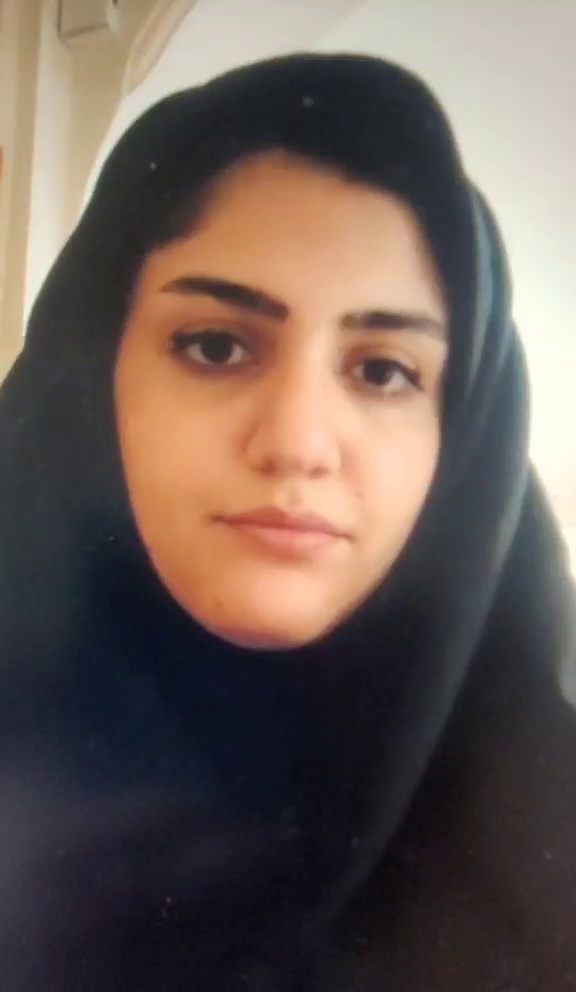

In [13]:
test[0]['image']

# ResNet50

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2

## Preparing Images

In [15]:
import numpy as np
from PIL import Image

# Assuming images is a list of PIL Image objects
images_np = []
labels = []
for i in range(3000):
    #example = dataset['train'][i]
    image = np.array(dataset['train'][i]['image'])
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_np = np.array(rgb_img)
    images_np.append(cv2.resize(img_np, (224, 224)))
    labels.append(dataset['train'][i]['label'])
# Now images_np should contain numpy arrays representing each image
print(images_np[0].shape)  # Check the shape of the first image numpy array
print(labels[0])

(224, 224, 3)
0


In [16]:
len(images_np)

3000

## Training the model

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [18]:
# Convert labels to one-hot encoding
labels_onehot = to_categorical(np.array(labels), num_classes=2)

# Convert images_np list to numpy array
images_np_np = np.array(images_np)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_np_np, labels_onehot, test_size=0.2, random_state=42)

In [19]:
# Print shapes for verification
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2400, 224, 224, 3)
y_train shape: (2400, 2)
X_test shape: (600, 224, 224, 3)
y_test shape: (600, 2)


In [ ]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
75/75 [==============================] - 21s 176ms/step - loss: 0.6101 - accuracy: 0.8758 - val_loss: 0.0856 - val_accuracy: 0.9800
Epoch 2/10
75/75 [==============================] - 9s 123ms/step - loss: 0.0566 - accuracy: 0.9883 - val_loss: 0.0494 - val_accuracy: 0.9867
Epoch 3/10
75/75 [==============================] - 9s 125ms/step - loss: 0.0288 - accuracy: 0.9929 - val_loss: 0.0311 - val_accuracy: 0.9900
Epoch 4/10
75/75 [==============================] - 8s 113ms/step - loss: 0.0182 - accuracy: 0.9962 - val_loss: 0.0187 - val_accuracy: 0.9967
Epoch 5/10
75/75 [==============================] - 9s 125ms/step - loss: 0.0099 - accuracy: 0.9996 - val_loss: 0.0185 - val_accuracy: 0.9933
Epoch 6/10
75/75 [==============================] - 9s 114ms/step - loss: 0.0064 - accuracy: 0.9996 - val_loss: 0.0110 - val_accuracy: 0.9967
Epoch 7/10
75/75 [==============================] - 9s 127ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0084 - val_accuracy: 0.9967
Epoch

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

19/19 [==============================] - 2s 91ms/step - loss: 0.0064 - accuracy: 0.9983
Test Loss: 0.0064434451051056385, Test Accuracy: 99.83333349227905%


In [ ]:
# Save the model
model.save('anti_spoofing_model_resnet50_deep_fullface.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing the model

In [20]:
# Path to your test images
test_images_dir = '/content/extracted_frames/test'

In [21]:
# Function to resize images in a directory
def resize_images(directory, target_size=(224, 224)):
    resized_images = []
    test_image_paths = []
    test_image_labels = []

    # Iterate over each image in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            label = filename.split('.')[0].split('_')[0]
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            resized_image = cv2.resize(image, target_size)

            # Append resized image, image path, and label
            resized_images.append(resized_image)
            test_image_paths.append(image_path)
            test_image_labels.append(int(label))  # Convert label to int

    # Convert lists to numpy arrays
    resized_images = np.array(resized_images)
    test_image_labels = np.array(test_image_labels)

    return resized_images, test_image_paths, test_image_labels

In [22]:
# Resize images in test directory
resized_images, test_image_paths, test_image_labels = resize_images(test_images_dir)

# Check the shape of resized images
print("Resized images shape:", resized_images.shape)

Resized images shape: (33, 224, 224, 3)


In [23]:
# Convert labels to one-hot encoding
test_image_labels_onehot = to_categorical(test_image_labels, num_classes=2)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(resized_images, test_image_labels_onehot)

1/1 [==============================] - 0s 141ms/step - loss: 1.7041 - accuracy: 0.7188


### Wrong Answers

In [ ]:
import os

# Directory containing the images
image_directory = test_images_dir

# Get the predicted labels for the test images
predictions = model.predict(resized_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Total test images: ", len(predicted_labels))
# Get the true labels
true_labels = np.argmax(test_image_labels_onehot, axis=1)

# Find the names of incorrectly classified images
incorrect_image_names = []
for index, (predicted_label, true_label) in enumerate(zip(predicted_labels, true_labels)):
    if predicted_label != true_label:
        image_name = os.listdir(image_directory)[index]
        incorrect_image_names.append(image_name)
print("Wrong: ", len(incorrect_image_names))
# Display the names of incorrectly classified images
for image_name in incorrect_image_names:
    print(f"Incorrectly classified image: {image_name}")

1/1 [==============================] - 0s 26ms/step
Total test images:  32
Wrong:  9
Incorrectly classified image: 0_fake_test_22.jpg
Incorrectly classified image: 1_real_test_8.jpg
Incorrectly classified image: 1_real_test_14.jpg
Incorrectly classified image: 1_real_test_11.jpg
Incorrectly classified image: 1_real_test_9.jpg
Incorrectly classified image: 1_real_test_10.jpg
Incorrectly classified image: 0_fake_test_7.jpg
Incorrectly classified image: 0_fake_test_11.jpg
Incorrectly classified image: 1_real_test_3.jpg


### Predictions

In [ ]:
import csv

In [ ]:
predictions = model.predict(resized_images)
predicted_scores = predictions[:, 1]
# Normalize scores between 0 and 1
predicted_scores_normalized = (predicted_scores - np.min(predicted_scores)) / (np.max(predicted_scores) - np.min(predicted_scores))

# Save predictions to a CSV file
output_file = 'predictions.csv'
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'liveness_score'])  # Header
    for i, filename in enumerate(test_image_paths):
        correct_filename = filename.split('/')[4].split('.')[0]
        correct_filename += ".mp4"
        writer.writerow([correct_filename, predicted_scores_normalized[i]])

print(f"Predictions saved to {output_file}")

1/1 [==============================] - 0s 25ms/step
Predictions saved to predictions.csv


## Testing the Model with Cropped Images (Using MTCNN)

In [24]:
!pip install mtcnn --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.3 MB/s eta 0:00:00


In [25]:
from mtcnn import MTCNN

In [26]:
def load_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

In [27]:
def detect_and_crop_faces(image_path, detector):
    image = Image.open(image_path)
    image_np = np.asarray(image)
    result = detector.detect_faces(image_np)
    if result:
        for person in result:
            bounding_box = person['box']
            keypoints = person['keypoints']

            # Crop the detected face
            x, y, width, height = bounding_box
            cropped_face = image_np[y:y+height, x:x+width]

            # Convert the cropped face back to an image
            cropped_face_image = Image.fromarray(cropped_face)

            return cropped_face_image
    return None

In [28]:
# Initialize the MTCNN face detector
detector = MTCNN()

In [29]:
# Directory containing the original images
test_image_paths = load_image_paths(test_images_dir)

# Directory to save cropped face images
output_dir = '/content/cropped_faces/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each image and save the cropped face with the original filename
for image_path in test_image_paths:
    cropped_face = detect_and_crop_faces(image_path, detector)
    # print("Image path is:", test_image_paths)
    if cropped_face:
        # Extract the original filename
        original_filename = os.path.basename(image_path)
        # Save the cropped face image with the original filename
        cropped_face.save(os.path.join(output_dir, original_filename))

1/1 [==============================] - 0s 32ms/step


In [30]:
# Resize images in test directory
cropped_resized_images, cropped_test_image_paths, cropped_test_image_labels = resize_images(output_dir)

# Check the shape of resized images
print("Resized images shape:", cropped_resized_images.shape)

Resized images shape: (33, 224, 224, 3)


In [31]:
# Convert labels to one-hot encoding
cropped_test_image_labels_onehot = to_categorical(cropped_test_image_labels, num_classes=2)

In [ ]:
# Evaluate the model
cropped_test_loss, cropped_test_accuracy = model.evaluate(cropped_resized_images, cropped_test_image_labels_onehot)

1/1 [==============================] - 0s 139ms/step - loss: 0.8393 - accuracy: 0.7188


In [ ]:
# Predictions
cropped_predictions = model.predict(cropped_resized_images)
cropped_predicted_scores = cropped_predictions[:, 1]  # Assuming class 1 corresponds to index 1 in predictions

# Normalize scores between 0 and 1
cropped_predicted_scores_normalized = (cropped_predicted_scores - np.min(cropped_predicted_scores)) / (np.max(cropped_predicted_scores) - np.min(cropped_predicted_scores))

1/1 [==============================] - 0s 25ms/step


In [ ]:
# Save predictions to a CSV file
output_file = 'predictions.csv'
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'liveness_score', 'liveness_score_crop'])  # Header
    for i, filename in enumerate(test_image_paths):
        writer.writerow([filename, predicted_scores_normalized[i], cropped_predicted_scores_normalized[i]])

print(f"Predictions saved to {output_file}")

Predictions saved to predictions.csv


# Testing Google model

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

In [33]:
# Step 1: Load pretrained model and processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head
model.classifier = nn.Linear(model.config.hidden_size, 2)
nn.init.xavier_uniform_(model.classifier.weight)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [34]:
# Step 2: Convert data to PyTorch tensors and permute dimensions
# Normalize the image data
X_train_pt = torch.tensor(X_train / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_pt = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_pt = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_pt = torch.tensor(y_test, dtype=torch.long).to(device)


In [35]:
# Step 3: Define optimizer and criterion for the classifier head
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5)  # Only optimize classifier parameters
criterion = nn.CrossEntropyLoss()

In [36]:
# Step 4: Training loop
model.train()
epochs = 15
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, torch.argmax(batch_labels, dim=1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/15, Loss: 85.32642370462418
Epoch 2/15, Loss: 71.27150690555573
Epoch 3/15, Loss: 61.57638555765152
Epoch 4/15, Loss: 55.00446879863739
Epoch 5/15, Loss: 50.49847862124443
Epoch 6/15, Loss: 47.284194737672806
Epoch 7/15, Loss: 44.84917551279068
Epoch 8/15, Loss: 42.87762239575386
Epoch 9/15, Loss: 41.18519252538681
Epoch 10/15, Loss: 39.668936520814896
Epoch 11/15, Loss: 38.273439168930054
Epoch 12/15, Loss: 36.9696801006794
Epoch 13/15, Loss: 35.74257443845272
Epoch 14/15, Loss: 34.58400775492191
Epoch 15/15, Loss: 33.48910477757454


In [38]:
# Step 5: Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning the entire model
optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.BCEWithLogitsLoss()  # Use this if model outputs logits

# Ensure your targets are float
y_train_pt = torch.tensor(y_train_pt, dtype=torch.float)
y_test_pt = torch.tensor(y_test_pt, dtype=torch.float)

# Training loop remains similar
for epoch in range(15):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Fine-tuning Epoch {epoch+1}/{15}, Train Loss: {total_loss:.4f}")


<ipython-input-38-391ac97d86a6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_pt = torch.tensor(y_train_pt, dtype=torch.float)
<ipython-input-38-391ac97d86a6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_pt = torch.tensor(y_test_pt, dtype=torch.float)


Fine-tuning Epoch 1/15, Train Loss: 30.1228
Fine-tuning Epoch 2/15, Train Loss: 19.2256
Fine-tuning Epoch 3/15, Train Loss: 13.1220
Fine-tuning Epoch 4/15, Train Loss: 8.9411
Fine-tuning Epoch 5/15, Train Loss: 6.0971
Fine-tuning Epoch 6/15, Train Loss: 4.1831
Fine-tuning Epoch 7/15, Train Loss: 2.9008
Fine-tuning Epoch 8/15, Train Loss: 2.0612
Fine-tuning Epoch 9/15, Train Loss: 1.5155
Fine-tuning Epoch 10/15, Train Loss: 1.1547
Fine-tuning Epoch 11/15, Train Loss: 0.9069
Fine-tuning Epoch 12/15, Train Loss: 0.7297
Fine-tuning Epoch 13/15, Train Loss: 0.5988
Fine-tuning Epoch 14/15, Train Loss: 0.4995
Fine-tuning Epoch 15/15, Train Loss: 0.4230


In [39]:
# Normalize the image data
X_train_pt = torch.tensor(X_train / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_pt = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_pt = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_pt = torch.tensor(y_test, dtype=torch.long).to(device)

In [40]:
import torch

# Ensure your model and tensors are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming X_test_pt and y_test_pt are preprocessed and available on the correct device
X_test_pt = X_test_pt.to(device)
y_test_pt = y_test_pt.to(device)

# Set the model to evaluation mode
model.eval()
correct = 0
total = 0
batch_size = 32  # Set your batch size

with torch.no_grad():
    for i in range(0, len(X_test_pt), batch_size):
        batch_inputs = X_test_pt[i:i+batch_size]
        batch_labels = y_test_pt[i:i+batch_size]

        # Ensure the inputs are on the correct device
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(pixel_values=batch_inputs)
        _, predicted = torch.max(outputs.logits, 1)

        total += batch_labels.size(0)
        correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

accuracy = 100 * correct / total
print(f"Final Accuracy on test set: {accuracy:.2f}%")


Final Accuracy on test set: 99.83%


In [43]:
# Set the model to evaluation mode
model.eval()
correct = 0
total = 0
total_loss = 0.0
batch_size = 32  # Set your batch size

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for accuracy calculation

with torch.no_grad():
    for i in range(0, len(X_test_pt), batch_size):
        batch_inputs = X_test_pt[i:i+batch_size]
        batch_labels = y_test_pt[i:i+batch_size]

        # Ensure the inputs are on the correct device
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, torch.argmax(batch_labels, dim=1))

        total_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += batch_labels.size(0)
        correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

average_loss = total_loss / len(X_test_pt)
accuracy = 100 * correct / total

print(f"Final Accuracy on test set: {accuracy:.2f}%")
print(f"Final Loss on test set: {average_loss:.4f}")


Final Accuracy on test set: 99.83%
Final Loss on test set: 0.0001


In [46]:
import torch
import csv
import numpy as np

# Set the model to evaluation mode
model.eval()

# Ensure your data is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_test_pt = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

predictions = []

with torch.no_grad():
    for i in range(0, len(X_test_pt), batch_size):
        batch_inputs = X_test_pt[i:i+batch_size]
        batch_inputs = batch_inputs.to(device)
        outputs = model(pixel_values=batch_inputs)
        scores = outputs.logits.softmax(dim=1)[:, 1].cpu().numpy()  # Assuming binary classification
        predictions.extend(scores)

# Normalize scores between 0 and 1
predicted_scores_normalized = (np.array(predictions) - np.min(predictions)) / (np.max(predictions) - np.min(predictions))

In [47]:
# Save predictions to a CSV file
output_file = 'Google_predictions.csv'
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'liveness_score'])  # Header
    for i, filename in enumerate(test_image_paths):
        correct_filename = filename.split('/')[4].split('.')[0]
        correct_filename += ".mp4"
        print(correct_filename)
        writer.writerow([correct_filename, predicted_scores_normalized[i]])

print(f"Predictions saved to {output_file}")

0_fake_test_9.mp4
1_real_test_5.mp4
0_fake_test_18.mp4
0_fake_test_10.mp4
0_fake_test_16.mp4
0_fake_test_3.mp4
0_fake_test_14.mp4
0_fake_test_22.mp4
0_fake_test_4.mp4
1_real_test_6.mp4
0_fake_test_17.mp4
0_fake_test_24.mp4
0_fake_test_6.mp4
0_fake_test_8.mp4
0_fake_test_5.mp4
0_fake_test_21.mp4
0_fake_test_20.mp4
1_real_test_8.mp4
1_real_test_11.mp4
1_real_test_9.mp4
0_fake_test_13.mp4
1_real_test_10.mp4
1_real_test_7.mp4
0_fake_test_7.mp4
0_fake_test_2.mp4
1_real_test_13.mp4
0_fake_test_11.mp4
0_fake_test_1.mp4
1_real_test_1.mp4
1_real_test_4.mp4
1_real_test_2.mp4
0_fake_test_12.mp4
1_real_test_3.mp4
Predictions saved to Google_predictions.csv


### Testing Cropped Data

In [50]:
# Normalize the image data and convert to PyTorch tensors
cropped_test_images_pt = torch.tensor(cropped_resized_images / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
cropped_test_labels_pt = torch.tensor(cropped_test_image_labels_onehot, dtype=torch.long).to(device)

# Set the model to evaluation mode
model.eval()

correct = 0
total = 0
total_loss = 0.0
batch_size = 32  # Set your batch size

criterion = nn.CrossEntropyLoss()  # Assuming you are using CrossEntropyLoss for multi-class classification

with torch.no_grad():
    for i in range(0, len(cropped_test_images_pt), batch_size):
        batch_inputs = cropped_test_images_pt[i:i+batch_size]
        batch_labels = cropped_test_labels_pt[i:i+batch_size]

        # Ensure the inputs are on the correct device
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, torch.argmax(batch_labels, dim=1))

        total_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += batch_labels.size(0)
        correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

average_loss = total_loss / len(cropped_test_images_pt)
accuracy = 100 * correct / total

print(f"Final Accuracy on test set: {accuracy:.2f}%")
print(f"Final Loss on test set: {average_loss:.4f}")

Final Accuracy on test set: 63.64%
Final Loss on test set: 0.0257


In [51]:
# Normalize the image data and convert to PyTorch tensors
cropped_test_images_pt = torch.tensor(cropped_resized_images / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

# Set the model to evaluation mode
model.eval()

cropped_predictions = []

with torch.no_grad():
    for i in range(0, len(cropped_test_images_pt), batch_size):
        batch_inputs = cropped_test_images_pt[i:i+batch_size]
        batch_inputs = batch_inputs.to(device)

        outputs = model(pixel_values=batch_inputs)
        scores = outputs.logits.softmax(dim=1)[:, 1].cpu().numpy()  # Assuming binary classification
        cropped_predictions.extend(scores)

# Convert predictions list to numpy array
cropped_predictions = np.array(cropped_predictions)

# Normalize scores between 0 and 1
cropped_predicted_scores_normalized = (cropped_predictions - np.min(cropped_predictions)) / (np.max(cropped_predictions) - np.min(cropped_predictions))

In [52]:
# Ensure your predictions are numpy arrays for indexing
predicted_scores_normalized = np.array(predicted_scores_normalized)
cropped_predicted_scores_normalized = np.array(cropped_predicted_scores_normalized)

output_file = 'predictions.csv'
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'liveness_score', 'liveness_score_crop'])  # Header
    for i, filename in enumerate(test_image_paths):
        writer.writerow([filename, predicted_scores_normalized[i], cropped_predicted_scores_normalized[i]])

print(f"Predictions saved to {output_file}")

Predictions saved to predictions.csv
